In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [18]:
df = pd.read_csv("data/victims_of_fall_V1.csv")

In [19]:
print("\n".join((
    f"In the document there are {df.isna().values.sum()} NaN values out of {df.values.size} values.",
    f"The sample (row) with most values has {df.isna().sum(axis=1).max()} NaN values out of {df.shape[1]} values.",
    f"The feature (column) with most values has {df.isna().sum().max()} NaN values out of {df.shape[0]} values."
)))
print("="*80)

In the document there are 146 NaN values out of 12705 values.
The sample (row) with most values has 4 NaN values out of 33 values.
The feature (column) with most values has 44 NaN values out of 385 values.


In [20]:
import itertools 
columns = ["Età", "Sesso", "Altezza soggetto", "Peso", "BMI", "Altezza di precipitazione (m)", "mgh"]

nan_df = df.isna()
set_permutations = set()
nan_dict = []
for i in range(1, 6):
   for combination in list(itertools.combinations(columns, i)): 
     grouped_df = nan_df
     for column in combination:
       grouped_df = grouped_df[grouped_df[column] == True]
     if len(grouped_df) > 0:
      nan_dict.append({combination : len(grouped_df)})

In [5]:
sorted(nan_dict, key = lambda x: (-list(x.values())[0]))

[{('BMI',): 44},
 {('Peso',): 42},
 {('mgh',): 42},
 {('Peso', 'BMI'): 42},
 {('Peso', 'mgh'): 42},
 {('BMI', 'mgh'): 42},
 {('Peso', 'BMI', 'mgh'): 42},
 {('Altezza soggetto',): 17},
 {('Altezza soggetto', 'BMI'): 17},
 {('Altezza soggetto', 'Peso'): 15},
 {('Altezza soggetto', 'mgh'): 15},
 {('Altezza soggetto', 'Peso', 'BMI'): 15},
 {('Altezza soggetto', 'Peso', 'mgh'): 15},
 {('Altezza soggetto', 'BMI', 'mgh'): 15},
 {('Altezza soggetto', 'Peso', 'BMI', 'mgh'): 15},
 {('Età',): 1},
 {('Età', 'Peso'): 1},
 {('Età', 'BMI'): 1},
 {('Età', 'mgh'): 1},
 {('Età', 'Peso', 'BMI'): 1},
 {('Età', 'Peso', 'mgh'): 1},
 {('Età', 'BMI', 'mgh'): 1},
 {('Età', 'Peso', 'BMI', 'mgh'): 1}]

In [145]:
dataset = df.dropna()
dataset.Sesso = pd.Categorical(dataset.Sesso)
dataset.Sesso = dataset.Sesso.cat.codes


labels = dataset.filter(["Altezza di precipitazione (m)"])
labels = labels.rename(columns={"Altezza di precipitazione (m)" : "Altezza"})
dataset = dataset.drop(["Unnamed: 0","Altezza di precipitazione (m)", "Casi", "mgh"], axis = 1)

E:\anaconda\lib\site-packages\pandas\core\generic.py:5507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Altezza
18         53
21         53
12         52
9          48
24         48
6          44
15         43
dtype: int64


<AxesSubplot:xlabel='Altezza'>

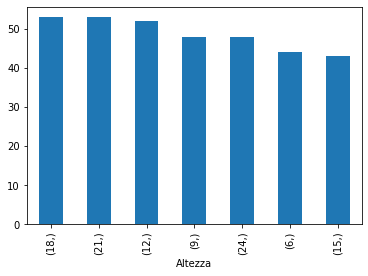

In [7]:
classes_freq = labels.value_counts()
print(classes_freq)
classes_freq.plot(kind='bar')

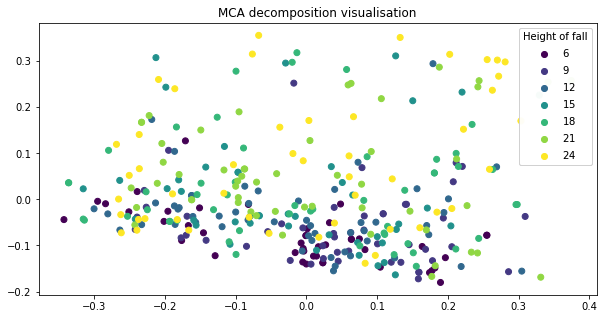

In [8]:
import prince 

mca = prince.MCA()

mca = mca.fit(dataset) # same as calling ca.fs_r(1)
xseries = mca.transform(dataset) # same as calling ca.fs_r_sup(df_new) for *another* test set.
yseries = [y[0] for y in labels.values]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
scatter = axes.scatter(xseries[:][0], xseries[:][1], c=yseries)
axes.set_title(f"MCA decomposition visualisation")

# Produce a legend for the ranking (colors). 
legend1 = axes.legend(*scatter.legend_elements(),
                    loc="upper right", title="Height of fall")
axes.add_artist(legend1)

plt.show()

In [146]:
dataset_variants = []
dataset_variants.append(("complete_dataset", dataset))
dataset_variants.append(("dataset_only_totals", dataset.filter(["Sesso", "Età", "Altezza soggetto", "Peso", "BMI", "TESTA", "TORACE", "ADDOME", "SCHELETRO"])))
dataset_variants.append(("dataset_only_binary", dataset.drop(["TESTA", "TORACE", "ADDOME", "SCHELETRO"], axis=1)))

In [203]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA, TruncatedSVD

class MaskedPCA(BaseEstimator, TransformerMixin):

    def __init__(self, n_components=2, mask=None):  
        # mask should contain selected cols. Suppose it is boolean to avoid code overhead
        self.n_components = n_components
        self.mask = mask

    def fit(self, X, y = None):
        self.pca = PCA(n_components=self.n_components)
        mask = self.mask
        mask = self.mask if self.mask is not None else slice(None)
        self.pca.fit(X[:, mask])
        return self

    def transform(self, X, y = None):
        mask = self.mask if self.mask is not None else slice(None)
        pca_transformed = self.pca.transform(X[:, mask])
        if self.mask is not None:
            remaining_cols = X[:, ~mask]
            return np.hstack([remaining_cols, pca_transformed])
        else:
            return pca_transformed
        

class MaskedSVD(BaseEstimator, TransformerMixin):

    def __init__(self, n_components=2, mask=None):  
        # mask should contain selected cols. Suppose it is boolean to avoid code overhead
        self.n_components = n_components
        self.mask = mask

    def fit(self, X, y = None):
        self.svd = TruncatedSVD(n_components=self.n_components)
        mask = self.mask
        mask = self.mask if self.mask is not None else slice(None)
        self.svd.fit(X[:, mask])
        return self

    def transform(self, X, y = None):
        mask = self.mask if self.mask is not None else slice(None)
        svd_transformed = self.svd.transform(X[:, mask])
        if self.mask is not None:
            remaining_cols = X[:, ~mask]
            return np.hstack([remaining_cols, svd_transformed])
        else:
            return svd_transformed

In [149]:
import numpy as np

np_dataset= dataset.to_numpy()
mask = np.arange(np_dataset.shape[1]) > 4

mpca = MaskedPCA(n_components=2, mask=mask)

transformed = mpca.fit(np_dataset).transform(np_dataset)

# check whether first five columns are equal
from numpy.testing import assert_array_equal
assert_array_equal(np_dataset[:, :5], transformed[:, :5])

In [220]:
%%time
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from multiprocessing import cpu_count

all_performance = []
for dataset in dataset_variants:
    dataset_name = dataset[0]
    dataset = dataset[1].to_numpy()
    
    mask = np.arange(dataset.shape[1]) > 4
    print(mask)
    pipe = Pipeline([
        ('reduce_dim', MaskedPCA(mask = mask)),
        ('regressor', DecisionTreeRegressor())
        ])
    
    n_features_to_test = np.arange(1, dataset.shape[1] - 5)
    max_depth_to_test = [5, 10, 30]
    reduce_dim_to_test = [MaskedPCA(mask = mask), MaskedSVD(mask = mask)]
    
    params = {'reduce_dim': reduce_dim_to_test,
              'reduce_dim__n_components': n_features_to_test,
              'regressor__max_depth': max_depth_to_test}
    
    labels_ = [x[0] for x in labels.to_numpy()]
    
    skf = StratifiedKFold(n_splits=10)
    gridsearch = GridSearchCV(pipe, params, cv=skf, n_jobs=cpu_count(), verbose=1, scoring = "neg_mean_squared_error", return_train_score=True).fit(X=dataset, y=labels)
    score = {
        "dataset_variant": dataset_name,
        "best_params": gridsearch.best_params_,
        "mean_test_score": gridsearch.best_score_
    }
    
    all_performance.append(score)

[False False False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
Fitting 10 folds for each of 138 candidates, totalling 1380 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1320 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 1380 out of 1380 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[False False False False False  True  True  True  True]
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[False False False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
Fitting 10 folds for each of 114 candidates, totalling 1140 fits


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s


Wall time: 8.12 s


[Parallel(n_jobs=8)]: Done 1140 out of 1140 | elapsed:    3.4s finished


In [221]:
pd.options.display.max_rows = 4000
pd.DataFrame(all_performance)

,dataset_variant,best_params,mean_test_score
0,complete_dataset,"{'reduce_dim': MaskedSVD(mask=array([False, Fa...",-26.720170
1,dataset_only_totals,"{'reduce_dim': MaskedSVD(mask=array([False, Fa...",-30.083119
2,dataset_only_binary,"{'reduce_dim': MaskedSVD(mask=array([False, Fa...",-30.249611


In [222]:
[print(x['best_params']) for x in all_performance]

{'reduce_dim': MaskedSVD(mask=array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]),
          n_components=8), 'reduce_dim__n_components': 8, 'regressor__max_depth': 5}
{'reduce_dim': MaskedSVD(mask=array([False, False, False, False, False,  True,  True,  True,  True]),
          n_components=1), 'reduce_dim__n_components': 1, 'regressor__max_depth': 5}
{'reduce_dim': MaskedSVD(mask=array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True]),
          n_components=1), 'reduce_dim__n_components': 1, 'regressor__max_depth': 5}


[None, None, None]